# LGBM을 활용한 베이스라인

In [66]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [16]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [74]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

train = pd.read_csv("/opt/ml/input/data/train_dataset/cv_train_data.csv", dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv("/opt/ml/input/data/train_dataset/cv_valid_data.csv", dtype=dtype, parse_dates=['Timestamp'])

### 1-1 DB 로딩

In [68]:
student_grade = pd.read_csv("/opt/ml/input/data/DB/student_grade.csv")
test_info = pd.read_csv("/opt/ml/input/data/DB/test_info.csv")
correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

student_grade = student_grade[["userID","grade","acc","count", "elapsed"]]
test_info = test_info[["testId","problem_number","type_number","acc","elapsed"]]

student_grade.columns = ["userID","grade","grade_acc","grade_count", "grade_elapsed"]
test_info.columns = ["testId","problem_count","type_count","test_acc","test_elapsed"]

## 2. Feature Engineering

In [69]:
def add_col(df):
    pre = df["testId"][0]
    count = df["answerCode"][0]
    c = 1
    new = []

    for idx, answer in zip(df["testId"],df["answerCode"]):
        if pre != idx :
            pre = idx
            new.append(0)
            c = 1
            count = answer
        else :
            new.append(count/c)
            c += 1
            count += answer
    df['cum_correct'] = new
    return df

In [70]:
def add_last_problem(df):
    new = []
    pre = df['testId'][0]
    for idx in df['testId']:
        if pre != idx :
            new[-1]=-1
            pre = idx
        new.append(0)
    df['last_problem'] = new
    return df

In [71]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    df = add_col(df)
    df = add_last_problem(df)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

    # 푸는 시간
    df['elapsed'] = diff
    df['elapsed'] = df['elapsed'].apply(lambda x : x if x <650 else None)
    # 앞 세자리 
    # 중간 세자리
    # 문제 번호
    df['grade']=df['testId'].apply(lambda x : int(x[1:4])//10)
    df['mid'] = df['testId'].apply(lambda x : int(x[-3:]))
    df['problem_number'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
    
    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, student_grade, on=['userID','grade'], how="left")
    df = pd.merge(df, test_info, on=['testId'], how="left")
    
    df['problem_position'] = df['problem_number'] / df["problem_count"]
    
    return df

In [19]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,cum_correct,last_problem,user_correct_answer,user_total_answer,...,test_sum,tag_mean,tag_sum,grade_acc,grade_elapsed,problem_count,type_count,test_acc,test_elapsed,problem_position
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1.0,0,NaN,0,...,1268.0,0.955022,637.0,0.791908,36.533784,7,2,0.952667,20.842105,0.142857
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,0,1.0,1,...,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105,0.285714
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1.0,0,2.0,2,...,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105,0.428571
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1.0,0,3.0,3,...,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105,0.571429
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1.0,0,4.0,4,...,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105,0.714286


In [ ]:
df.columns

## 3. Train/Test 데이터 셋 분리

In [13]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [30]:
# 마지막 문제만 추출
# df = df[df['last_problem']==-1].copy()

In [75]:
# 유저별 분리
# train, test = custom_train_test_split(df)
train = feature_engineering(train)
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,cum_correct,last_problem,user_correct_answer,user_total_answer,...,tag_mean,tag_sum,grade_acc,grade_count,grade_elapsed,problem_count,type_count,test_acc,test_elapsed,problem_position
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1.0,0,NaN,0,...,0.955022,637.0,0.791908,346,36.533784,7,2,0.952667,20.842105,0.142857
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,0,1.0,1,...,0.913187,3040.0,0.791908,346,36.533784,7,2,0.952667,20.842105,0.285714
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1.0,0,2.0,2,...,0.913187,3040.0,0.791908,346,36.533784,7,2,0.952667,20.842105,0.428571
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1.0,0,3.0,3,...,0.913187,3040.0,0.791908,346,36.533784,7,2,0.952667,20.842105,0.571429
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1.0,0,4.0,4,...,0.913187,3040.0,0.791908,346,36.533784,7,2,0.952667,20.842105,0.714286


In [76]:
test = feature_engineering(test)
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,cum_correct,last_problem,user_correct_answer,user_total_answer,...,tag_mean,tag_sum,grade_acc,grade_count,grade_elapsed,problem_count,type_count,test_acc,test_elapsed,problem_position
0,35,A040093001,A040000093,1,2020-01-02 23:30:13,2094,1.000000,0,NaN,0,...,0.51175,2047.0,0.923767,223,33.717514,5,1,0.502667,108.257261,0.2
1,35,A040093002,A040000093,0,2020-01-02 23:31:13,2094,1.000000,0,1.0,1,...,0.51175,2047.0,0.923767,223,33.717514,5,1,0.502667,108.257261,0.4
2,35,A040093003,A040000093,0,2020-01-02 23:31:56,2094,0.666667,0,1.0,2,...,0.51175,2047.0,0.923767,223,33.717514,5,1,0.502667,108.257261,0.6
3,35,A040093004,A040000093,0,2020-01-02 23:32:15,2094,0.500000,0,1.0,3,...,0.51175,2047.0,0.923767,223,33.717514,5,1,0.502667,108.257261,0.8
4,35,A040093005,A040000093,1,2020-01-02 23:35:06,2094,0.400000,-1,1.0,4,...,0.51175,2047.0,0.923767,223,33.717514,5,1,0.502667,108.257261,1.0


In [77]:
categorical_feats = ['problem_number','grade', 'mid','KnowledgeTag','problem_count','type_count']

for c in categorical_feats :
    train[c] = train[c].astype(int)
    train[c] = train[c].astype('category')
    test[c] = test[c].astype(int)
    test[c] = test[c].astype('category')

In [78]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum',
         'problem_number', 'elapsed', 'grade', 'mid',
         'grade_acc', 'grade_elapsed', 'problem_count', 'type_count', 'test_acc','test_elapsed','problem_position'
        ]

# ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
#        'KnowledgeTag', 'cum_correct', 'user_correct_answer',
#        'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
#        'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
#        'grade_acc', 'grade_elapsed', 'problem_count', 'type_count', 'test_acc',
#        'test_elapsed']

# categorical 처리!!!

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [79]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [80]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [82]:
model = lgb.train(
                    {'objective': 'binary','metric':'auc'},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=3000,
                    early_stopping_rounds=200
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1316760, number of negative: 695809
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 2012569, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654268 -> initscore=0.637854
[LightGBM] [Info] Start training from score 0.637854


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.845104	valid_1's auc: 0.837312
[200]	training's auc: 0.852973	valid_1's auc: 0.842274
[300]	training's auc: 0.857674	valid_1's auc: 0.844703
[400]	training's auc: 0.860844	valid_1's auc: 0.846165
[500]	training's auc: 0.863608	valid_1's auc: 0.847231
[600]	training's auc: 0.866413	valid_1's auc: 0.848486
[700]	training's auc: 0.868555	valid_1's auc: 0.849174
[800]	training's auc: 0.870699	valid_1's auc: 0.850026
[900]	training's auc: 0.872298	valid_1's auc: 0.85045
[1000]	training's auc: 0.873727	valid_1's auc: 0.850566
[1100]	training's auc: 0.87537	valid_1's auc: 0.850714
[1200]	training's auc: 0.876924	valid_1's auc: 0.851046
[1300]	training's auc: 0.878236	valid_1's auc: 0.851235
[1400]	training's auc: 0.879585	valid_1's auc: 0.851224
[1500]	training's auc: 0.880851	valid_1's auc: 0.851491
[1600]	training's auc: 0.882032	valid_1's auc: 0.851402
Early stopping, best iteration is:
[1488]	training's 

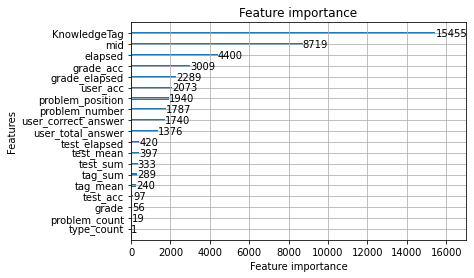

In [83]:
# INSTALL MATPLOTLIB IN ADVANCE
import matplotlib.pyplot as plt
_ = lgb.plot_importance(model)

## 5. Inference

In [84]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
test_csv_file_path = '/opt/ml/input/data/train_dataset/test_data.csv'
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [85]:
test_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [86]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# setting Categorical Varaible
for c in categorical_feats :
    test_df[c] = test_df[c].astype(int)
    test_df[c] = test_df[c].astype('category')

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [87]:
test_df.head(10)

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,cum_correct,last_problem,user_correct_answer,user_total_answer,user_acc,...,tag_mean,tag_sum,grade_acc,grade_count,grade_elapsed,problem_count,type_count,test_acc,test_elapsed,problem_position
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,0.857143,-1,717.0,1035,0.692754,...,0.560703,1658.0,0.655052,861,63.258152,8,2,0.655328,71.882009,1.000
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,0.857143,-1,465.0,670,0.694030,...,0.538664,1226.0,0.703529,425,65.061170,8,2,0.651883,68.405588,1.000
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,0.428571,-1,915.0,1316,0.695289,...,0.499044,1305.0,0.390593,489,22.142523,8,3,0.456728,39.127758,1.000
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,1.000000,-1,1031.0,1259,0.818904,...,0.408974,319.0,0.924757,412,55.127479,6,1,0.445743,42.072727,1.000
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,0.666667,-1,293.0,386,0.759067,...,0.610038,2589.0,0.817365,334,41.003559,7,1,0.640366,63.961745,1.000
5524,29,A020190005,A020000190,2020-10-22 04:38:45,8097,1.000000,-1,723.0,853,0.847597,...,0.712804,2199.0,0.891667,480,46.907090,5,1,0.739827,58.245017,1.000
6608,45,A040136005,A040000136,2020-10-23 08:24:19,2107,0.250000,-1,746.0,1083,0.688827,...,0.708647,3016.0,0.556075,214,79.701220,5,1,0.721815,49.997490,1.000
7301,53,A040140005,A040000140,2020-10-26 09:13:20,2110,0.500000,-1,362.0,692,0.523121,...,0.714736,2493.0,0.511416,657,39.562030,5,2,0.713235,30.707155,1.000
8112,58,A070159007,A070000159,2020-12-24 21:09:29,9122,0.142857,-1,295.0,810,0.364198,...,0.363158,552.0,0.230645,620,14.046555,8,3,0.477978,48.670908,0.875
9382,64,A070146008,A070000146,2020-12-29 04:30:22,9080,1.000000,-1,1058.0,1269,0.833727,...,0.538664,1226.0,0.617486,366,9.619335,8,2,0.651883,68.405588,1.000


In [88]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [91]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_add_feature_cv.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_add_feature_cv.csv
